# Import libraries + install dataset from R


In [1]:
from rdatasets import data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
from sklearn import linear_model
from matplotlib import style
style.use('ggplot')

# Dataset overview

In [2]:
df = data('cars')

In [3]:
df.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


In [4]:
df.describe()

,speed,dist
count,50.000000,50.000000
mean,15.400000,42.980000
std,5.287644,25.769377
min,4.000000,2.000000
25%,12.000000,26.000000
50%,15.000000,36.000000
75%,19.000000,56.000000
max,25.000000,120.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 928.0 bytes


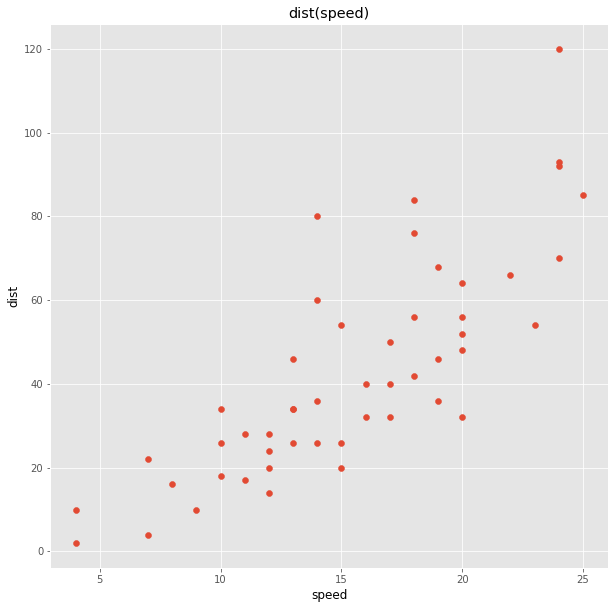

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter(df['speed'], df['dist'])
plt.title('dist(speed)')
plt.xlabel('speed', color='k')
plt.ylabel('dist', color='k')
plt.show()

# Regression with sklearn

Preparing data

In [7]:
predict = 'dist'
x = np.array(df.drop([predict], 1))
y = np.array(df[predict])
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.1)

Finding the 'best model'

In [8]:
best = 0
for _ in range(400):
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.1)

    linear = linear_model.Ridge()
    linear.fit(x_train,y_train)
    acc = linear.score(x_test,y_test)
    # print(acc)

    if acc>best:
        best = acc
        bestModel = linear
        
print(f'Best accuracy = {best}')

Best accuracy = 0.9562384088687786


Printing bias and weights

In [9]:
print("w: \n", bestModel.coef_)
print("b: \n", bestModel.intercept_)
a = bestModel.coef_
b = bestModel.intercept_

w: 
 [3.8597902]
b: 
 -16.260287387709766


Testing on test data

In [10]:
predictions = bestModel.predict(x_test)

In [11]:
for i in range(len(predictions)):
    print(predictions[i], x_test[i], y_test[i])

33.91698525395958 [13] 34
41.63656566037025 [15] 20
57.075726473191594 [19] 68
45.49635586357559 [16] 32
60.93551667639693 [20] 32


Plotting predictions for data points

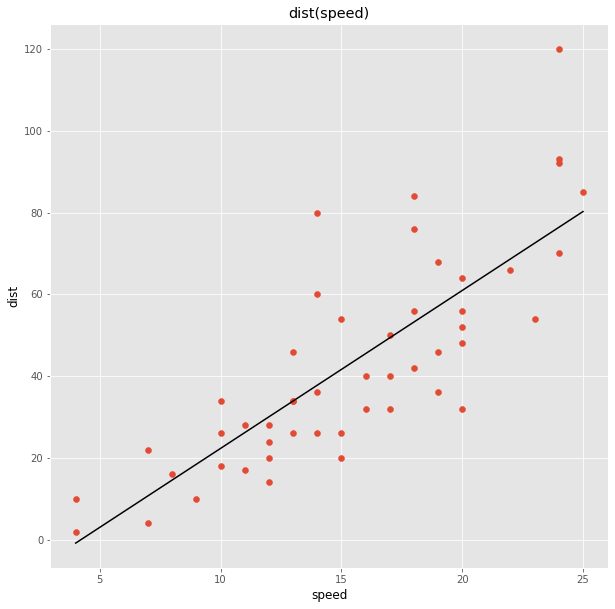

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(df['speed'], df['dist'])
plt.plot(df['speed'], a*df['speed']+b, color='k')
plt.title('dist(speed)')
plt.xlabel('speed', color='k')
plt.ylabel('dist', color='k')
plt.show()

Prediction for X = 9

In [13]:
print('X = ', df['speed'][5])
print('Y = ', df['speed'][5]*a + b)

X =  9
Y =  [18.47782444]


# My implementation of the algorythm

In [14]:
w0 = bestModel.intercept_
w1 = 10
y = y.reshape(x.shape)

Creating prediction and cost functions

In [15]:
def TPredict(theta, x):
  a = np.append(np.ones(x.shape[0]).reshape(x.shape), x, axis=1)
  return np.matmul(a, theta)
# Default without regularization (lambda = 0),  L2 if lam > 0
# If L1 = True and lam > 0, then regularization L1 will be used.
def Tcost(theta, x, y, lam=0, L1=False):
  yPred = TPredict(theta, x)
  if L1 is False:
    err = (yPred - y)**2 + lam*np.sum(theta**2)
  elif L1 is True:
    err =  (yPred - y)**2 + lam*np.sum(np.abs(theta))
  return (np.sum(err))

Implementation of batch gradient descent

In [16]:
def GradD(x, y, alpha = 0.005, epsilon = 10e-5):
  theta = np.array([1, 1]).reshape(2, 1)
  delta = 1
  i = 0
  a = np.append(np.ones(x.shape[0]).reshape(x.shape), x, axis=1)
  cost = Tcost(theta, x, y)
  while(delta > epsilon):
    grad = np.matmul(np.transpose(a), TPredict(theta, x) - y)
    theta = theta - alpha/x.shape[0] * grad
    costVal = Tcost(theta, x, y)
    cost = np.append(cost, costVal)
    delta = np.abs(cost[i+1] - cost[i])
    if((cost[i+1] - cost[i]) > 0):
      print('Reduce alpha')
      return
    i+=1
  print(f'Number of iterations = {i}')
  return theta

Comparing time when data is normalized and when it is not.

In [17]:
%%time
coefs = GradD(x, y)

Number of iterations = 9527
Wall time: 766 ms


In [18]:
print(coefs)

[[-17.44243671]
 [  3.9244508 ]]


In [19]:
%%time
# Test for normalized data
x_norm = (x - np.mean(x)) / np.std(x)
stheta = GradD(x_norm, y, alpha = 0.06, epsilon = 10e-10)
print(stheta)

Number of iterations = 245
[[42.97998905]
 [20.5841922 ]]
Wall time: 25.1 ms


Couting weights - they are similar to weights that i got from sklearn

In [20]:
ctheta = stheta[1:stheta.shape[0]] / np.array(np.std(x))
cthetazero = stheta[0] - np.sum(stheta[1:stheta.shape[0]] / np.array(np.std(x)) * np.array(np.mean(x)))
ctheta = np.array([ctheta, cthetazero], dtype='float64')
print(ctheta)

[[  3.93240778]
 [-17.57909081]]


Plotting graph with predictions for data points

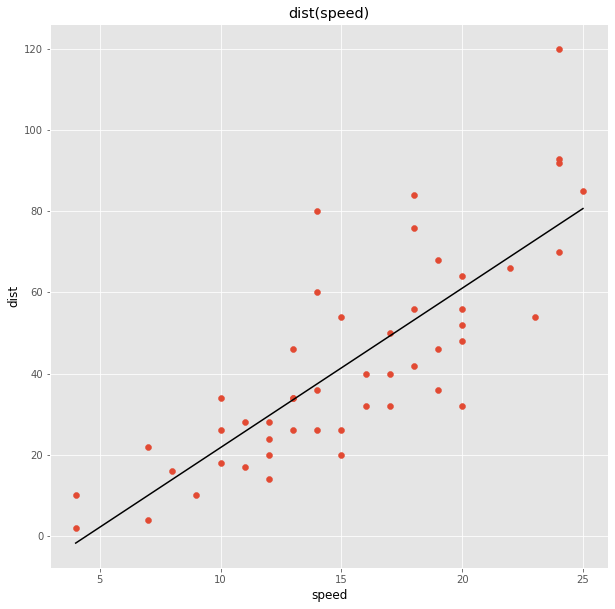

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(df['speed'], df['dist'])
plt.plot(df['speed'], coefs[1]*df['speed']+coefs[0], color='k')
plt.title('dist(speed)')
plt.xlabel('speed',  color='k')
plt.ylabel('dist',  color='k')
plt.show()